In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
import detect_and_track as dt

In [4]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()
## This is for progress bars only ... not sure what `%%capture` does.

In [5]:
from scipy.ndimage import label, generate_binary_structure
def alt_get_labels3d_np(da, crit):
    """Label events through time. (numpy array) 
    
    This version uses a specific structure matrix that
    is equivalent to specifying overlap in time.
    The difference from using a default generate_binary_structure(3, 2)
    matrix is that it handles merging/splitting a little more aggressively.
    """
    mask = np.where(da >= crit, 1, 0)
    assert len(mask.shape) == 3  # has to be time,lat,lon
    structure_matrix = np.array([[[False,  False, False],
        [ False,  True,  False],
        [False,  False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  False, False],
        [ False,  True,  False],
        [False,  False, False]]])
    la, nf = label(mask, structure=structure_matrix)
    # nf is just an integer
    return la, nf

In [6]:
def event_updater(arr, transformer_dict):
    """Updates labels to new values."""
    if isinstance(arr, xr.DataArray):
        lll = arr.values
    else:
        lll = arr
    new_labels = lll.copy()
    for k in transformer_dict:
        # make sure to identify points in lll otherwise you could be flipping values in new_labels.
        new_labels = np.where(lll==k, transformer_dict[k], new_labels)
    if isinstance(arr, xr.DataArray):
        new_labels = xr.DataArray(new_labels, dims=arr.dims, coords=arr.coords)
    return new_labels


def stitchLabels(labels):
    """Temporal concatenation of overlapping events."""
    # 
    # rules:
    # start from time=0 and march forward
    # for each new time:
    # - if an event does not overlap in space with a labeled event in time-1, it is given the next available label
    # - if an event overlaps one previous event, it inherits that label
    # - if an event overlaps more than one previous event, it inherits the smallest of the labels
    # This allows splitting of events
    print(f"SHAPE: {labels.shape} => {labels.shape[0]}")
    output = labels.copy()
    # initialize the labels:
    last_id = np.max(labels[0,:,:])
    for i in range(1,labels.shape[0]):
        slice1 = labels[i,:,:]
        nlbls = np.max(slice1)  # number of labels to check in current time.
#         print(f"Time: {i}, number of labels: {nlbls}")
        if nlbls == 0:
            continue # no labels to deal with
        slice0 = output[i-1,:,:] # make sure to look back at output b/c it has the "correct" labels.
        transformer = {}  # dict: keys are the "current label" and values are the "correct" label
        # every event gets an entry in transformer
        for b in range(1,nlbls+1):  # there are nlbls that start at 1
            previous_labels = np.where(slice1 == b, slice0, np.nan)
            ppl = np.unique(previous_labels[~np.isnan(previous_labels)])
            ppl = ppl[ppl!=0] # don't include non-events
#             print(f"b = {b}, ppl = {ppl}")
            if len(ppl) == 0:
                # indicates no overlap
                last_id += 1 
#                 print(f"No prev. label at point, so assign to {last_id}")
                transformer[b] = last_id
            elif len(ppl) == 1:
                # overlaps a single event, so continue that event
                transformer[b] = int(ppl[0])
            else:
                # continue the "oldest" event
                transformer[b] = int(np.min(ppl))
#         print(f"Time {i} Transformer: {transformer}")
        # update:
        output[i,:,:] = event_updater(slice1, transformer)
    return output
        

Text(0.5, 0.98, 'MERGE')

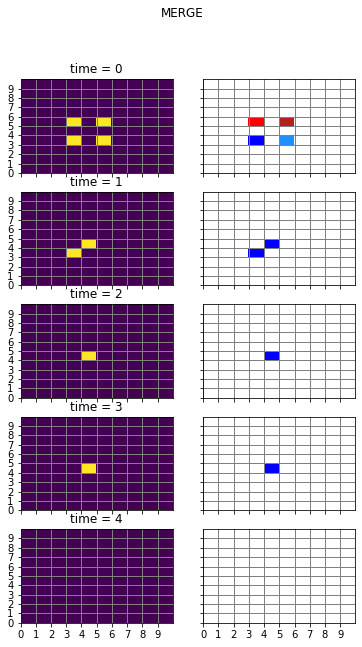

In [7]:
example01 = np.zeros((5,10,10))  # time, x, y
example01[0, [3,5], [3,5]] = 1
example01[0, 3, 5] = 1
example01[0, 5, 3] = 1
example01[1, [3,4], [3,4]] = 1
example01[[2,3], [4], [4]] = 1

# labs, numb = dt.get_labels_np(example01, 1)
# labs = stitchLabels(labs)
labs, numb = alt_get_labels3d_np(example01, 1)


# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6,10),nrows=5, ncols=2, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example01[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];
fig.suptitle("MERGE")

In [8]:
print(labs)

[[[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 2 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 3 0 4 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0

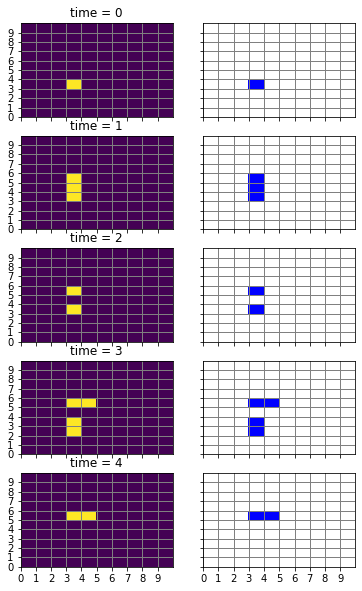

In [9]:
example02 = np.zeros((5,10,10))  # time, x, y
example02[0, 3, 3] = 1
example02[1, [3,4,5], 3] = 1
example02[2, [3,5], 3] = 1
example02[3, [2,3], 3] = 1
example02[3:, 5, [3,4]] = 1

# labs, numb = dt.get_labels_np(example02, 1)
# labs = stitchLabels(labs)

labs, numb = alt_get_labels3d_np(example02, 1)

# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6,10),nrows=5, ncols=2, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example02[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];



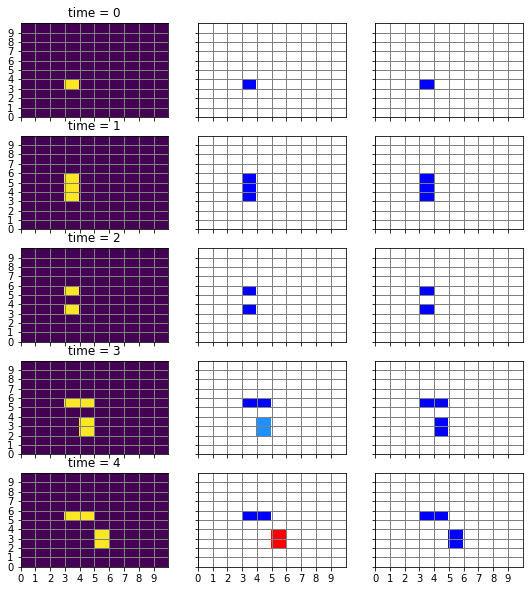

In [10]:
example03 = np.zeros((5,10,10))  # time, x, y
example03[0, 3, 3] = 1
example03[1, [3,4,5], 3] = 1
example03[2, [3,5], 3] = 1
example03[3, [2,3], 4] = 1
example03[3:, 5, [3,4]] = 1
example03[4, [2,3], 5] = 1


# labs, numb = dt.get_labels_np(example03, 1)
# labs = stitchLabels(labs)

labsA, numbA = dt.get_labels3d_np(example03, 1)

labs, numb = alt_get_labels3d_np(example03, 1)

# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(9,10),nrows=5, ncols=3, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example03[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,2].pcolormesh(labsA[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];




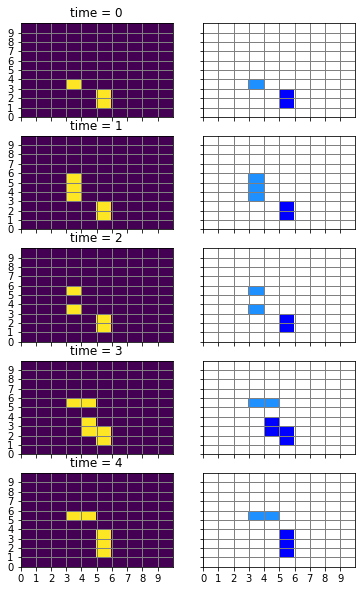

In [11]:
example04 = np.zeros((5,10,10))  # time, x, y
example04[0, 3, 3] = 1
example04[:, [1,2], 5] = 1
example04[1, [3,4,5], 3] = 1
example04[2, [3,5], 3] = 1
example04[3, [2,3], 4] = 1
example04[3:, 5, [3,4]] = 1
example04[4, [2,3], 5] = 1


# labs, numb = dt.get_labels_np(example04, 1)
# labs = stitchLabels(labs)
labs, numb = alt_get_labels3d_np(example04, 1)

# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6,10),nrows=5, ncols=2, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example04[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];

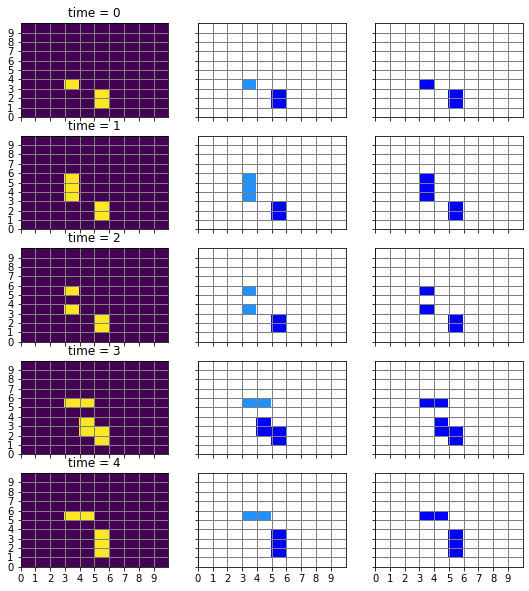

In [12]:
example05 = np.zeros((5,10,10))  # time, x, y
example05[0, 3, 3] = 1
example05[:, [1,2], 5] = 1
example05[1, [3,4,5], 3] = 1
example05[2, [3,5], 3] = 1
example05[3, [2,3], 4] = 1
example05[3:, 5, [3,4]] = 1
example05[4, [2,3], 5] = 1


# labs, numb = dt.get_labels_np(example03, 1)
# labs = stitchLabels(labs)

labsA, numbA = dt.get_labels3d_np(example05, 1)

labs, numb = alt_get_labels3d_np(example05, 1)

# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(9,10),nrows=5, ncols=3, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example05[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,2].pcolormesh(labsA[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];


In [50]:
for i in range(1, 10):
    print(i)

1
2
3
4
5
6
7
8
9


In [98]:
A = np.array([np.nan, 3, np.nan, 0, np.nan, 3, 0, 0, 1])
B = np.unique(A[~np.isnan(A)])

In [103]:
np.unique(A[~np.isnan(A)])

array([0., 1., 3.])

In [63]:
def proc_np(arr):
    arr *= 2

In [109]:
A = np.array([0, 1, 4])
A = A[A!=0]
print(A)

[1 4]


In [104]:
np.intersect1d(np.nonzero(A), ~np.isnan(A))

array([0, 1])

In [107]:
A != 0

array([ True,  True,  True, False,  True,  True, False, False,  True])

In [40]:
generate_binary_structure(3,2)

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])